# Simple Harmonic Motion
## Analysis of Multiple Fits

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit
# Set the number of digits to be printed after the decimal point
np.set_printoptions(precision=4)

In [ ]:
df1 = pd.read_csv("273_Lab4_100_no_plate.csv")

print(list(df1.columns))
substrings_to_delete = ["Ping Echo", "Date and Time Run"]
columns_to_drop = [
    col for col in df1.columns
    if any(sub in col for sub in substrings_to_delete)
]
df1.drop(columns=columns_to_drop, inplace=True)

# rename first csv column numbers
rename_mapping = {}
# The runs we want to change go from 9 to 28 (20 runs total)
for old_run_num in range(9, 29):
    new_run_num = old_run_num - 8 # Renumbers 9 to 1, 10 to 2, ..., 28 to 20

    # The pattern to find the old run number in the column header
    # e.g., looks for ' #9' at the end of the string
    old_pattern = f' #{old_run_num}'

    # The string to replace it with
    new_string = f' #{new_run_num}'

    # Iterate through all current column names
    for col in df1.columns:
        # Check if the column name ends with the old run pattern
        if col.endswith(old_pattern):
            # Create the new column name
            new_col = col.replace(old_pattern, new_string)

            # Add the mapping to the dictionary
            rename_mapping[col] = new_col

# 2. Rename the columns using the mapping
df1 = df1.rename(columns=rename_mapping)

print(list(df1.columns))

['Date and Time Run #9', 'Time (s) Run #9', 'Position (m) Run #9', 'Velocity (m/s) Run #9', 'Acceleration (m/s²) Run #9', 'Ping Echo Time (s) Run #9', 'Date and Time Run #10', 'Time (s) Run #10', 'Position (m) Run #10', 'Velocity (m/s) Run #10', 'Acceleration (m/s²) Run #10', 'Ping Echo Time (s) Run #10', 'Date and Time Run #11', 'Time (s) Run #11', 'Position (m) Run #11', 'Velocity (m/s) Run #11', 'Acceleration (m/s²) Run #11', 'Ping Echo Time (s) Run #11', 'Date and Time Run #12', 'Time (s) Run #12', 'Position (m) Run #12', 'Velocity (m/s) Run #12', 'Acceleration (m/s²) Run #12', 'Ping Echo Time (s) Run #12', 'Date and Time Run #13', 'Time (s) Run #13', 'Position (m) Run #13', 'Velocity (m/s) Run #13', 'Acceleration (m/s²) Run #13', 'Ping Echo Time (s) Run #13', 'Date and Time Run #14', 'Time (s) Run #14', 'Position (m) Run #14', 'Velocity (m/s) Run #14', 'Acceleration (m/s²) Run #14', 'Ping Echo Time (s) Run #14', 'Date and Time Run #15', 'Time (s) Run #15', 'Position (m) Run #15', 

In [3]:
df2 = pd.read_csv("273_Lab4_100_small_plate.csv")
df3 = pd.read_csv("273_Lab4_250_no_plate.csv")
df4 = pd.read_csv("273_Lab4_250_small_plate.csv")
df5 = pd.read_csv("273_Lab4_250_large_plate.csv")

dfArr = [df1, df2, df3, df4, df5]
plotTitles = ["100_no_plate", "100_small_plate", "250_no_plate", "250_small_plate", "250_large_plate"]

In [4]:
m1 = 102.4 # 100g no plate
m2 = 110.9 # 100g small plate

m3 = 253.4 # 250g no plate
m4 = 256.9 # 250g small plate
m5 = 268.2 # 250g large plate

masses = [m1,m2,m3,m4,m5]

Check that the format of the file is as expected, the top row should contain the title of the column, for example: "Time (s) Run #1", "Position (m) Run #1", etc. The columns of interest are Time and Position and if you have multiple runs in the file these should correspond to different run numbers. *This example expects 20 runs in the input file.*

## Reminder on how to obtain fit values and uncertainties using Scipy curve_fit
#### Documentation at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#### More information about curve fitting at https://python4mpia.github.io/fitting_data/least-squares-fitting.html
#### First define a damped sine function
### $$A e^{-Bt} \sin(Wt+P) + C$$
Parameters are: amplitude (A), damping (B), frequency (W), phase (P) and offset (C)

In [5]:
def my_sin(x, amplitude, damp, freq, phase, offset):
    return amplitude * np.exp(-damp * x) * np.sin(x * freq + phase) + offset


### Histogram given Statistical analysis of the fit results of 20 repeated experiments
Perform fit from first to last specified data point. Note that data is collected at 20 Hz, i.e. a new position measurement is made every 50 ms.

For the position measurement error, the Pasco motion sensor has resolution of 1 mm.

Store the fit parameters in an array.



Avg   7.156620 +/- 0.000361, std dev 0.001573
Avg   6.989961 +/- 0.027040, std dev 0.166683
Avg   6.213361 +/- 0.146583, std dev 1.106680
Avg   5.802788 +/- 0.136895, std dev 1.193427
Avg   5.540990 +/- 0.121982, std dev 1.188936


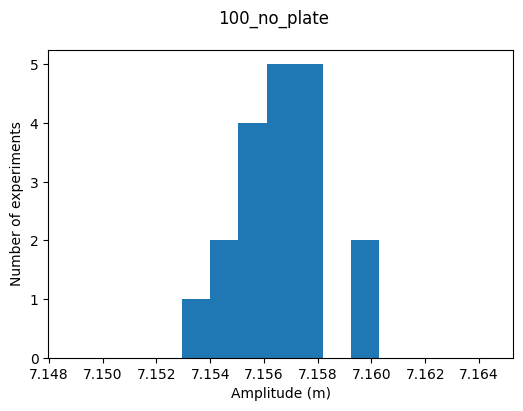

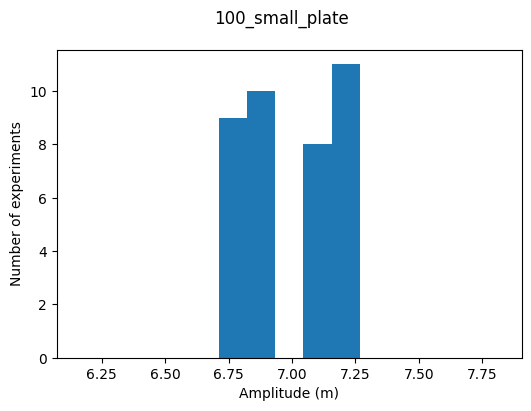

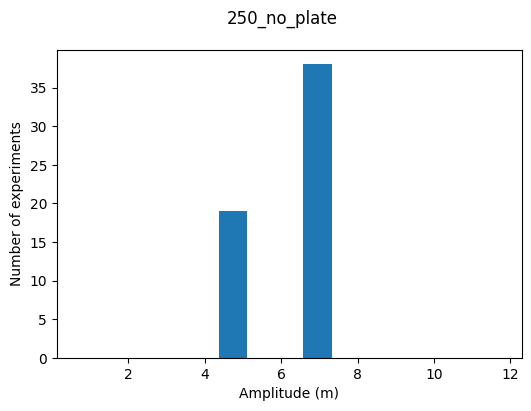

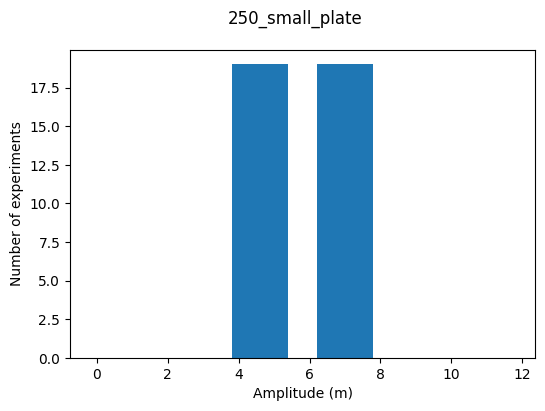

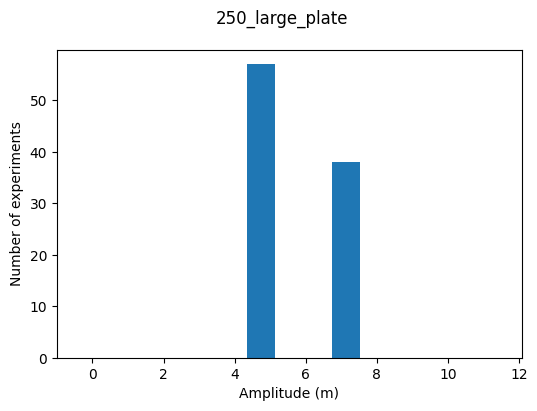

In [6]:
A = []
B = []
W = []
P = []
C = []

guess_damp = 0.01
guess_freq = 5
guess_phase = -3

# first and last points used in the fit
first = 0
last = first+600


for j in range(0, len(dfArr)):
  df = dfArr[j]
  plot_title = plotTitles[j]
  for i in range(19):
    x=df["Time (s) Run #"+str(i+1)].dropna()
    x=x.to_numpy()
    x=x.transpose()
    y=df["Position (m) Run #"+str(i+1)].dropna()
    y=y.to_numpy()
    y=y.transpose()

    guess_amplitude = np.max(y)-np.mean(y)
    guess_offset = np.mean(y)
    p0_guess=[guess_amplitude, guess_damp, guess_freq, guess_phase, guess_offset]

    dy = np.full(len(x),0.001)
    fit = curve_fit(my_sin, x[first:last], y[first:last], sigma=dy[first:last], p0=p0_guess, absolute_sigma=True)

    # Extract fit results: parameters
    param = fit[0]
    A.append(param[0])
    B.append(param[1])
    W.append(param[2])
    P.append(param[3])
    C.append(param[4])


      
  plt.figure(figsize=(6,4))
  # Specify which parameter to plot and the axis label
  parameter = W
  label_title = 'Amplitude (m)'

  lowx = np.mean(parameter)-5*np.std(parameter)
  highx = np.mean(parameter)+5*np.std(parameter)
  plt.hist(parameter, bins=15, range=(lowx, highx))
  plt.xlabel(label_title)
  plt.ylabel('Number of experiments')
  plt.suptitle(plot_title)
  # plt.show()
  print('Avg   ' + "{:.6f}".format(np.mean(parameter)) + 
      " +/- " + "{:.6f}".format(np.std(parameter)/np.sqrt(len(parameter))) + 
      ", std dev " + "{:.6f}".format(np.std(parameter)))


### Real Stuff


In [7]:
alpha_means = np.array([0.006064, 0.024354, 0.017913, 0.018567, 0.022260])

# standard errors of mean (SEM) for each configuration (the ± you printed)
alpha_sems = np.array([0.000370, 0.003005, 0.002342, 0.001765, 0.001608])

# masses in kg
masses = np.array([0.1024, 0.1109, 0.2534, 0.2569, 0.2682])


0.1024
=== FITTED PARAMETERS ===
B (alpha) = 0.006064 ± 0.000380 s⁻¹
W (omega) = 7.156620 ± 0.000371 rad/s

=== NATURAL FREQUENCY ===
W0 = 7.156623 ± 0.000371 rad/s

=== SPRING CONSTANT ===
k = 5.24465 ± 0.00054 N/m

=== DAMPING COEFFICIENT ===
b = 0.00124 ± 0.00008 kg/s

=== FINAL RESULTS ===
Natural frequency W0 = 7.156623 ± 0.000371 rad/s
Spring constant k = 5.24465 ± 0.00054 N/m
Damping coefficient b = 0.00124 ± 0.00008 kg/s


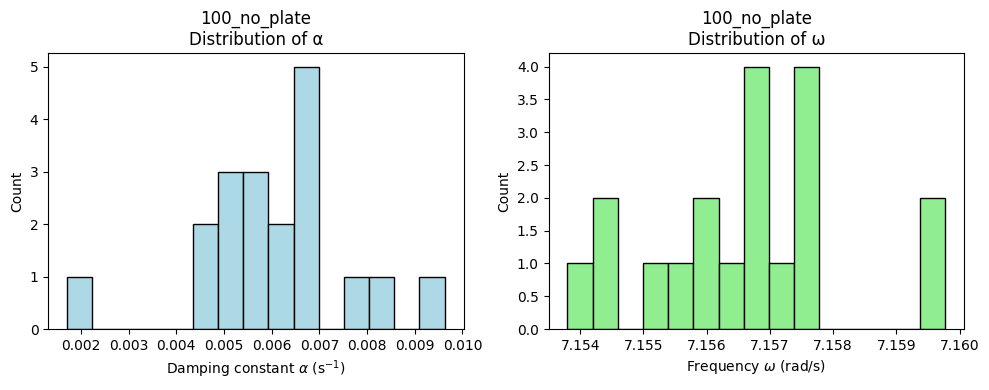

0.1109
=== FITTED PARAMETERS ===
B (alpha) = 0.042645 ± 0.000907 s⁻¹
W (omega) = 6.823303 ± 0.000869 rad/s

=== NATURAL FREQUENCY ===
W0 = 6.823436 ± 0.000869 rad/s

=== SPRING CONSTANT ===
k = 5.16342 ± 0.00131 N/m

=== DAMPING COEFFICIENT ===
b = 0.00946 ± 0.00020 kg/s

=== FINAL RESULTS ===
Natural frequency W0 = 6.823436 ± 0.000869 rad/s
Spring constant k = 5.16342 ± 0.00131 N/m
Damping coefficient b = 0.00946 ± 0.00020 kg/s


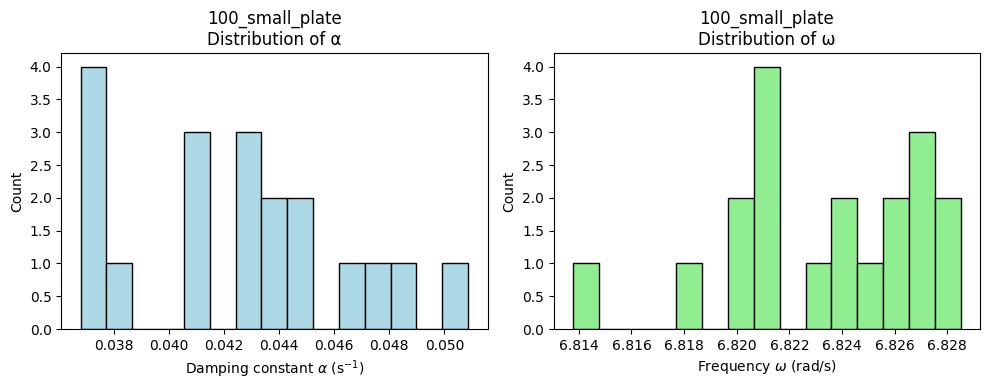

0.2534
=== FITTED PARAMETERS ===
B (alpha) = 0.005029 ± 0.000394 s⁻¹
W (omega) = 4.660160 ± 0.000711 rad/s

=== NATURAL FREQUENCY ===
W0 = 4.660163 ± 0.000711 rad/s

=== SPRING CONSTANT ===
k = 5.50312 ± 0.00168 N/m

=== DAMPING COEFFICIENT ===
b = 0.00255 ± 0.00020 kg/s

=== FINAL RESULTS ===
Natural frequency W0 = 4.660163 ± 0.000711 rad/s
Spring constant k = 5.50312 ± 0.00168 N/m
Damping coefficient b = 0.00255 ± 0.00020 kg/s


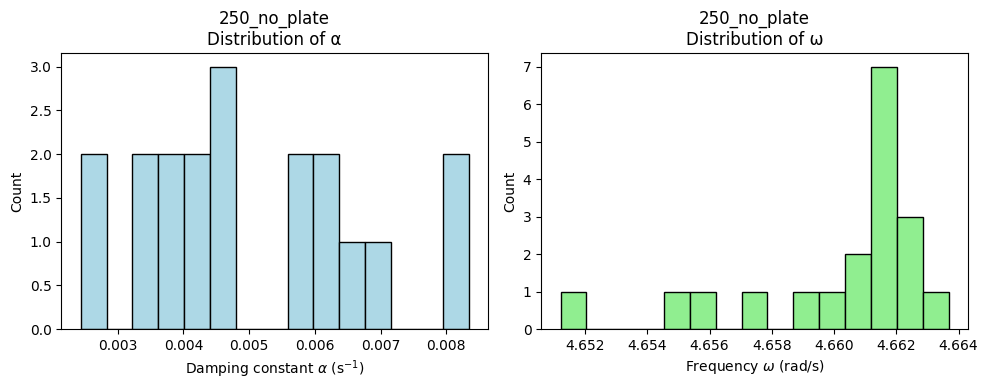

0.2569
=== FITTED PARAMETERS ===
B (alpha) = 0.020530 ± 0.000475 s⁻¹
W (omega) = 4.571068 ± 0.000329 rad/s

=== NATURAL FREQUENCY ===
W0 = 4.571114 ± 0.000329 rad/s

=== SPRING CONSTANT ===
k = 5.36795 ± 0.00077 N/m

=== DAMPING COEFFICIENT ===
b = 0.01055 ± 0.00024 kg/s

=== FINAL RESULTS ===
Natural frequency W0 = 4.571114 ± 0.000329 rad/s
Spring constant k = 5.36795 ± 0.00077 N/m
Damping coefficient b = 0.01055 ± 0.00024 kg/s


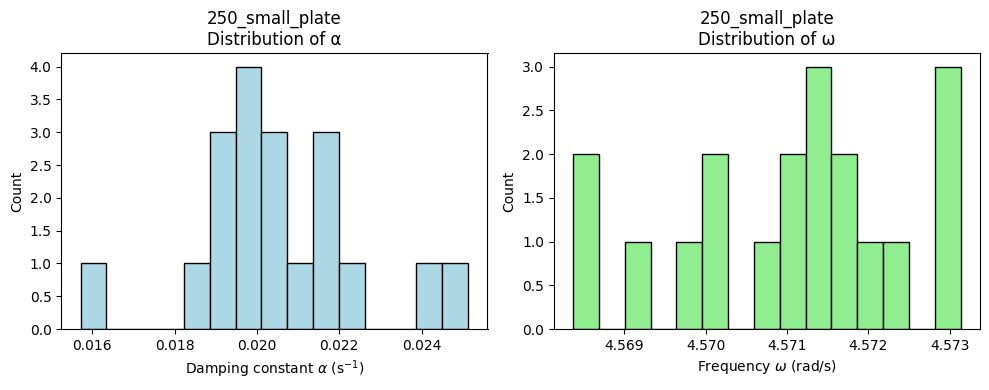

0.2682
=== FITTED PARAMETERS ===
B (alpha) = 0.037032 ± 0.000681 s⁻¹
W (omega) = 4.493797 ± 0.000769 rad/s

=== NATURAL FREQUENCY ===
W0 = 4.493950 ± 0.000769 rad/s

=== SPRING CONSTANT ===
k = 5.41646 ± 0.00185 N/m

=== DAMPING COEFFICIENT ===
b = 0.01986 ± 0.00037 kg/s

=== FINAL RESULTS ===
Natural frequency W0 = 4.493950 ± 0.000769 rad/s
Spring constant k = 5.41646 ± 0.00185 N/m
Damping coefficient b = 0.01986 ± 0.00037 kg/s


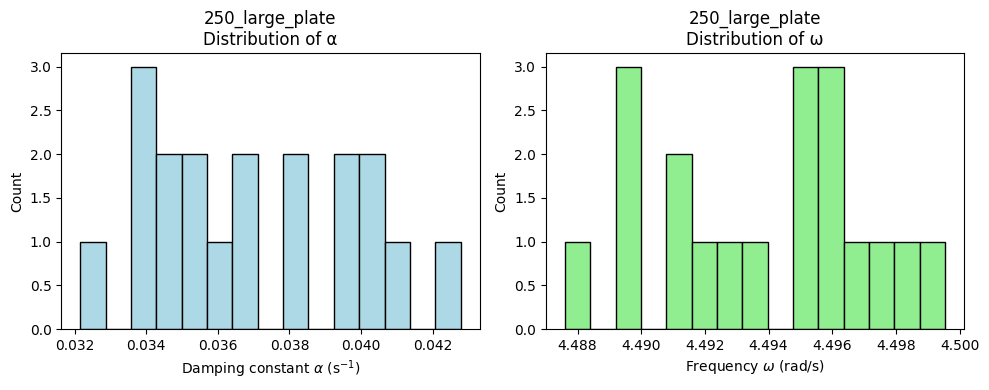

In [8]:
import numpy as np
from scipy.optimize import curve_fit

# Define the damped sine function: A*exp(-B*t)*sin(W*t + P) + C
def my_sin(t, A, B, W, P, C):
    return A * np.exp(-B * t) * np.sin(W * t + P) + C

guess_damp = 0.01
guess_freq = 5
guess_phase = -3

# first and last points used in the fit
first = 0
last = first + 600


for j in range(0, len(dfArr)):
    A = []
    B = []  # This is alpha = b/(2m)
    W = []  # This is omega (damped frequency)  
    P = []  # This is phase
    C = []  # This is offset

    df = dfArr[j]
    plot_title = plotTitles[j]

    mass = masses[j] # in kg

    print("===========================================================")
    print(mass)
    print("===========================================================")

    for i in range(1,20):
        x = df["Time (s) Run #"+str(i)].dropna()
        x = x.to_numpy()
        x = x.transpose()
        y = df["Position (m) Run #"+str(i)].dropna()
        y = y.to_numpy()
        y = y.transpose()

        guess_amplitude = np.max(y) - np.mean(y)
        guess_offset = np.mean(y)
        p0_guess = [guess_amplitude, guess_damp, guess_freq, guess_phase, guess_offset]

        dy = np.full(len(x), 0.001)
        fit = curve_fit(my_sin, x[first:last], y[first:last], sigma=dy[first:last], 
                    p0=p0_guess, absolute_sigma=True)

        # Extract fit results: parameters
        param = fit[0]
        A.append(param[0])
        B.append(param[1])
        W.append(param[2])
        P.append(param[3])
        C.append(param[4])

    # Convert to numpy arrays
    A, B, W, P, C = np.array(A), np.array(B), np.array(W), np.array(P), np.array(C)

    # Calculate averages
    A_avg, B_avg, W_avg, P_avg, C_avg = np.mean(A), np.mean(B), np.mean(W), np.mean(P), np.mean(C)

    # Calculate uncertainties in the means
    sigma_A = np.std(A, ddof=1) / np.sqrt(len(A))
    sigma_B = np.std(B, ddof=1) / np.sqrt(len(B))
    sigma_W = np.std(W, ddof=1) / np.sqrt(len(W))
    sigma_P = np.std(P, ddof=1) / np.sqrt(len(P))
    sigma_C = np.std(C, ddof=1) / np.sqrt(len(C))

    print("=== FITTED PARAMETERS ===")
    print(f"B (alpha) = {B_avg:.6f} ± {sigma_B:.6f} s⁻¹")
    print(f"W (omega) = {W_avg:.6f} ± {sigma_W:.6f} rad/s")

    # Calculate natural frequency W0
    W0_avg = np.sqrt(W_avg**2 + B_avg**2)

    # Derivatives for W0
    dW0_dW = W_avg / W0_avg
    dW0_dB = B_avg / W0_avg

    sigma_W0 = np.sqrt((dW0_dW * sigma_W)**2 + (dW0_dB * sigma_B)**2)

    print(f"\n=== NATURAL FREQUENCY ===")
    print(f"W0 = {W0_avg:.6f} ± {sigma_W0:.6f} rad/s")

    # Calculate spring constant k
    k_avg = mass * (W_avg**2 + B_avg**2)

    # Derivatives for k
    dk_dW = 2 * mass * W_avg
    dk_dB = 2 * mass * B_avg

    sigma_k = np.sqrt((dk_dW * sigma_W)**2 + (dk_dB * sigma_B)**2)

    print(f"\n=== SPRING CONSTANT ===")
    print(f"k = {k_avg:.5f} ± {sigma_k:.5f} N/m")

    # Calculate damping coefficient b
    b_avg = 2 * mass * B_avg
    sigma_b = 2 * mass * sigma_B

    print(f"\n=== DAMPING COEFFICIENT ===")
    print(f"b = {b_avg:.5f} ± {sigma_b:.5f} kg/s")

    print(f"\n=== FINAL RESULTS ===")
    print(f"Natural frequency W0 = {W0_avg:.6f} ± {sigma_W0:.6f} rad/s")
    print(f"Spring constant k = {k_avg:.5f} ± {sigma_k:.5f} N/m") 
    print(f"Damping coefficient b = {b_avg:.5f} ± {sigma_b:.5f} kg/s")


        # --- HISTOGRAMS: α (damping) and ω (frequency) ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: Damping constant α
    axes[0].hist(B, bins=15, color='lightblue', edgecolor='black')
    axes[0].set_xlabel(r'Damping constant $\alpha$ (s$^{-1}$)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'{plot_title}\nDistribution of α')

    # Right: Angular frequency ω
    axes[1].hist(W, bins=15, color='lightgreen', edgecolor='black')
    axes[1].set_xlabel(r'Frequency $\omega$ (rad/s)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'{plot_title}\nDistribution of ω')

    plt.tight_layout()
    plt.show()


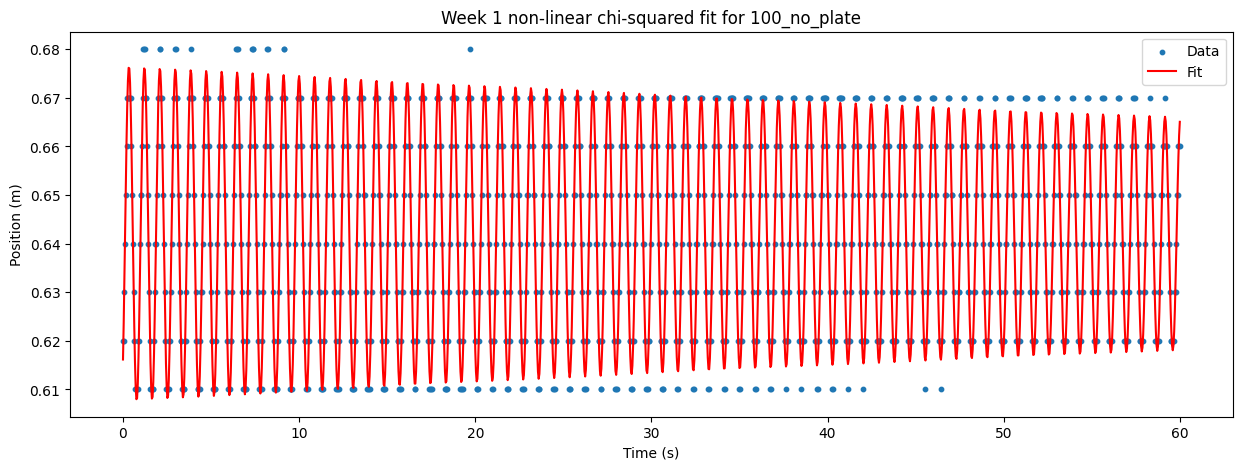

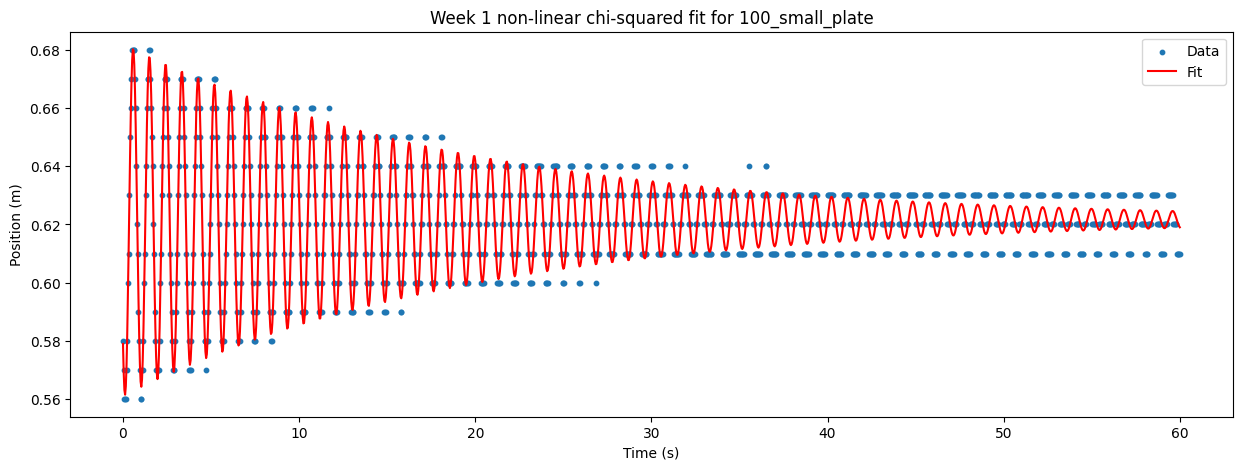

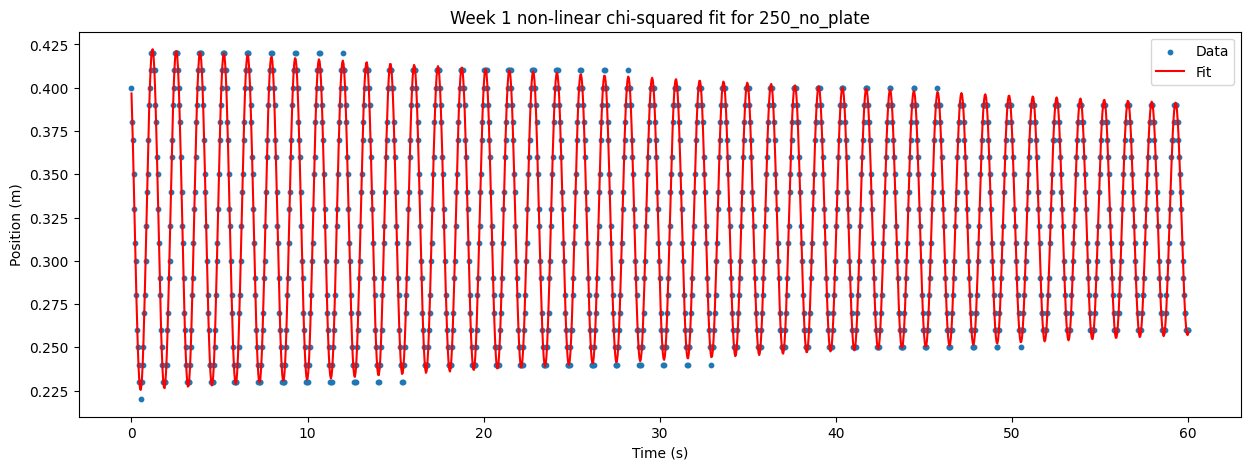

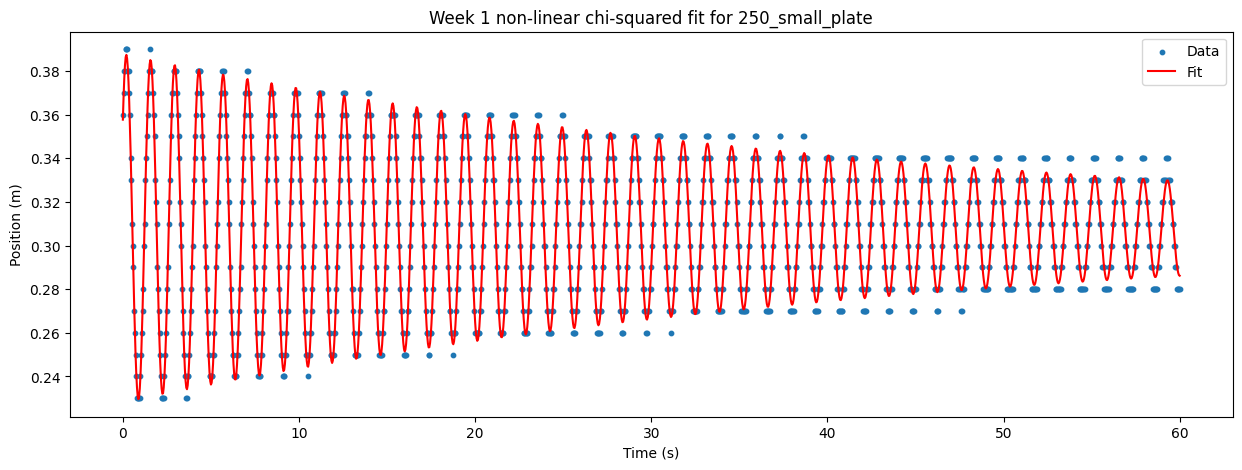

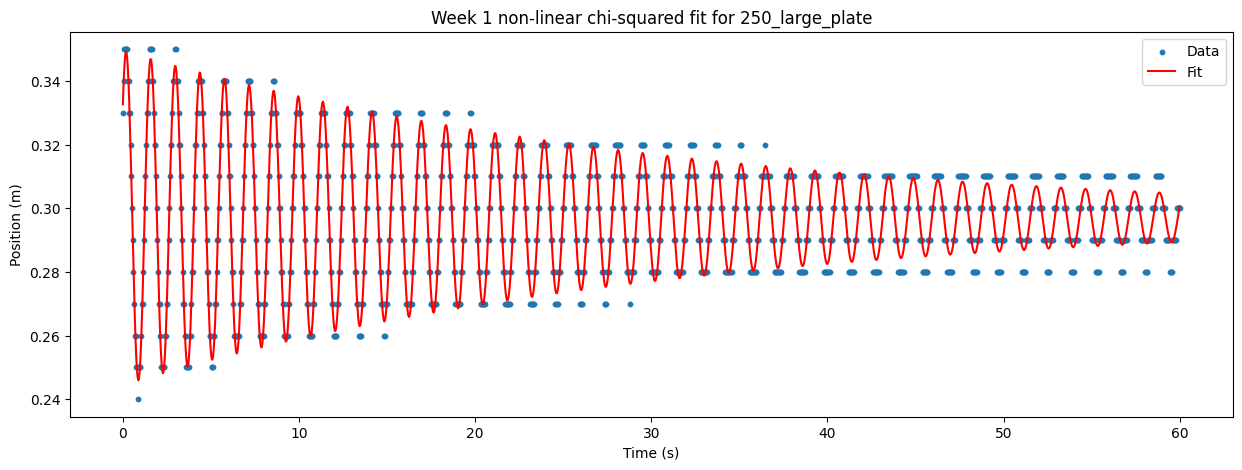

     Configuration         A   sigma_A     alpha  sigma_alpha     omega  \
0     100_no_plate -0.034483  0.000120  0.006088     0.000262  7.156649   
1  100_small_plate -0.060530  0.000149  0.050864     0.000257  6.813784   
2     250_no_plate -0.099086  0.000121  0.006518     0.000092  4.651216   
3  250_small_plate -0.079877  0.000129  0.021696     0.000135  4.570776   
4  250_large_plate -0.052590  0.000136  0.032157     0.000233  4.498609   

   sigma_omega       phi  sigma_phi         C   sigma_C    omega0  \
0     0.000258 -3.991019   0.003443  0.642049  0.000041  7.156651   
1     0.000259 -5.499949   0.002513  0.621689  0.000041  6.813974   
2     0.000090 -0.822947   0.001196  0.324060  0.000041  4.651221   
3     0.000136 -2.468139   0.001648  0.307894  0.000041  4.570828   
4     0.000238 -2.397437   0.002654  0.297043  0.000041  4.498724   

   sigma_omega0         k   sigma_k         b   sigma_b  
0      0.000258  5.244688  0.000378  0.001247  0.000054  
1      0.000259  5

: 

In [ ]:
def damped_sine(x, A, alpha, omega, phi, C):
    return A * np.exp(-alpha * x) * np.sin(omega * x + phi) + C

# Arrays to store results
results = []

# If you have masses and titles for each dataset
masses = [0.1024, 0.1109, 0.2534, 0.2569, 0.2682]  # in kg

# Loop over all 5 week 2 datasets
for j in range(0, len(dfArr)):
    mass = masses[j]
    plot_title = plotTitles[j]
    df = dfArr[j]

    # Use only the first Run
    time_col = "Time (s) Run #1"
    pos_col = "Position (m) Run #1"
    
    x = df[time_col].dropna().to_numpy()
    y = df[pos_col].dropna().to_numpy()

    # Initial guesses for fit parameters
    guess_A = np.max(y) - np.mean(y)
    guess_alpha = 0.01
    guess_omega = 5
    guess_phi = -3
    guess_C = np.mean(y)
    p0 = [guess_A, guess_alpha, guess_omega, guess_phi, guess_C]

    # Measurement uncertainty (1 mm sensor resolution)
    dy = np.full(len(x), 0.001)

    # Fit the damped sine function
    first, last = 0, min(len(x), 600)  # adjust last if dataset shorter
    fit_params, cov_matrix = curve_fit(damped_sine, x[first:last], y[first:last], sigma=dy[first:last],
                                       p0=p0, absolute_sigma=True)

    # Extract fit parameters and uncertainties
    A, alpha, omega, phi, C = fit_params
    sigma_A, sigma_alpha, sigma_omega, sigma_phi, sigma_C = np.sqrt(np.diag(cov_matrix))

    # Compute natural frequency and uncertainty
    omega0 = np.sqrt(omega**2 + alpha**2)
    sigma_omega0 = np.sqrt((omega/omega0 * sigma_omega)**2 + (alpha/omega0 * sigma_alpha)**2)

    # Compute spring constant and uncertainty
    k = mass * omega0**2
    sigma_k = 2 * mass * omega0 * sigma_omega0

    # Compute damping coefficient and uncertainty
    b = 2 * mass * alpha
    sigma_b = 2 * mass * sigma_alpha

    # Store results
    results.append({
        'Configuration': plot_title,
        'A': A, 'sigma_A': sigma_A,
        'alpha': alpha, 'sigma_alpha': sigma_alpha,
        'omega': omega, 'sigma_omega': sigma_omega,
        'phi': phi, 'sigma_phi': sigma_phi,
        'C': C, 'sigma_C': sigma_C,
        'omega0': omega0, 'sigma_omega0': sigma_omega0,
        'k': k, 'sigma_k': sigma_k,
        'b': b, 'sigma_b': sigma_b
    })

    # Optional: Plot data and fit
    y_fit = damped_sine(x, *fit_params)
    plt.figure(figsize=(15,5))
    plt.scatter(x, y, s=10, label='Data')
    plt.plot(x, y_fit, 'r-', label='Fit')
    plt.title("Week 1 non-linear chi-squared fit for " + plot_title)
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.show()

# Convert results to a dataframe for easy viewing
results_df = pd.DataFrame(results)
print(results_df)
